In [1]:
#%matplotlib inline
%matplotlib notebook
from scipy.stats import rv_continuous
from scipy.special import gamma
from scipy.interpolate import interp1d
import numpy as np
import emcee
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from numpy import exp, sqrt
from scipy.integrate import quad, dblquad
from matplotlib.colors import LogNorm
from scipy.integrate import quad
import scipy.optimize as optimize
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.neighbors import KDTree
import sys
import lmfit
from py_unsio import *
import pymc
import os
from pymodelfit import FunctionModel1DAuto
import wkbl
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm
import wkbl.astro.nbody_essentials as nbe
import cfalcon
CF =cfalcon.CFalcon()
import iminuit
from iminuit import Minuit, describe, Struct
import probfit
import yt
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = "/data/POL/HALOB/output_00417"
#path = "/media/arturo/ARTUROTECA/OUTPUTS/HaloB/output_00417"
myhalo = wkbl.Galaxy_Hound(path,"halo,gas,stars",getcen=False,comov=True)

loading Dark matter..
loading Stars..
loading Gas..


In [3]:
#halos = yt.load("Halo_B_halos_hop/catalog/catalog.0.h5")
halos = yt.load("rockstar_halos/halos_0.0.bin")

halos_data = halos.all_data()

yt : [INFO     ] 2017-10-13 16:38:59,941 Parameters: current_time              = 4.3311513124e+17 s
yt : [INFO     ] 2017-10-13 16:38:59,942 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-10-13 16:38:59,943 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-10-13 16:38:59,944 Parameters: domain_right_edge         = [ 13.97424126  13.97424126  13.97424126]
yt : [INFO     ] 2017-10-13 16:38:59,946 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-10-13 16:38:59,947 Parameters: current_redshift          = -5.7932358369e-05
yt : [INFO     ] 2017-10-13 16:38:59,948 Parameters: omega_lambda              = 0.723999977112
yt : [INFO     ] 2017-10-13 16:38:59,949 Parameters: omega_matter              = 0.275999993086
yt : [INFO     ] 2017-10-13 16:38:59,950 Parameters: hubble_constant           = 0.70300000906


In [4]:
print "a_exp = {0}".format(myhalo.p.aexp)
print myhalo.dm.pos3d[:,0].min(),myhalo.dm.pos3d[:,0].max()
print halos_data['particle_position_x'].in_units('kpc').min(),halos_data['particle_position_x'].in_units('kpc').max()

yt : [INFO     ] 2017-10-13 16:39:00,001 Allocating for 3.345e+03 particles (index particle type 'all')
yt : [INFO     ] 2017-10-13 16:39:00,017 Identified 1.209e+03 octs


a_exp = 1.00005792136
0.00394935 19914.6
6225.09184741 kpc 12154.1056123 kpc


In [5]:
ok,rho,_= CF.getDensity(np.array(myhalo.st.pos3d.reshape(len(myhalo.st.pos3d)*3),dtype=np.float32), myhalo.st.mass)
centro_rho = myhalo.st.pos3d[np.where(rho == rho.max())][0]
print "density",centro_rho
myhalo.center_shift(centro_rho)

density [ 9684.75195312  9882.64746094  9817.22949219]


In [6]:

h_x = halos_data['halos', u'particle_position_x'].in_units('kpc')
h_y = halos_data['halos', u'particle_position_y'].in_units('kpc')
h_z = halos_data['halos', u'particle_position_z'].in_units('kpc')
h_rvir = halos_data['halos', u'virial_radius'].in_units('kpc')
h_m = halos_data['halos',u'particle_mass'].in_units('Msun')


In [7]:
myhalo.r_virial(600,rotate=False)

starting
stackted
start histogram
 done


In [8]:
h_x = np.array(h_x) - centro_rho[0] + 19
h_y = np.array(h_y) - centro_rho[1] + 19
h_z = np.array(h_z) - centro_rho[2] + 19
h_r = np.sqrt(h_x**2 + h_y**2 + h_z**2)
in_r200 = np.where(h_r<myhalo.r200)
halos_x = h_x[in_r200]
halos_y = h_y[in_r200]
halos_z = h_z[in_r200]
halos_rvir = h_rvir[in_r200] 
halos_r = h_r[in_r200]
halos_mass = h_m[in_r200]

In [9]:
print h_r.min(), h_r.max()
print myhalo.r200
print halos_z.min(), halos_z.max()


4.87562127712 3506.11662803
166.9921875
-152.723614792 148.974417496


In [10]:
#halos.field_list

In [11]:
bin_num = 100
xedges = np.linspace(-200,200,bin_num)
yedges = np.linspace(-200,200,bin_num)
lim = 2e6
# Sort out Particles
H, xedges, yedges = np.histogram2d(myhalo.dm.pos3d[:,0],myhalo.dm.pos3d[:,1], bins=(xedges, yedges),weights=myhalo.dm.mass)
H = H.T

<IPython.core.display.Javascript object>


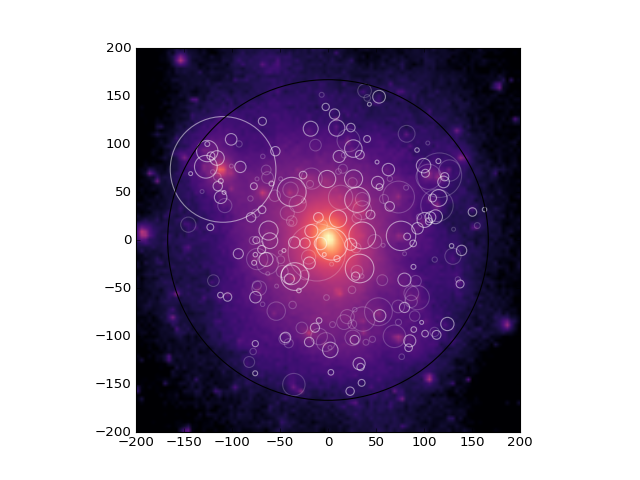

In [12]:
fig, ax = plt.subplots()
plt.imshow(H, interpolation='bilinear', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           norm=LogNorm(vmin=8e6, vmax=8e9))

for i in range(0,len(halos_r)):
    if halos_rvir[i] == halos_rvir.max():
        continue
    if halos_z[i] < 0:
        alpha=0.5
    else:
        alpha=0.2
    circle = plt.Circle(((halos_x[i]),(halos_y[i])),halos_rvir[i],
                        color='w',lw=1, fill=False,alpha=alpha)
    ax.add_patch( circle )

circle = plt.Circle(((0),(0)),myhalo.r200, color='k',lw=1, fill=False)
ax.add_patch( circle )

In [13]:
bin_num = 100
xedges = np.linspace(-200,200,bin_num)
yedges = np.linspace(-200,200,bin_num)
lim = 2e6
# Sort out Particles
Hz, xedges, yedges = np.histogram2d(myhalo.dm.pos3d[(myhalo.dm.r<myhalo.r200),0],
                                    myhalo.dm.pos3d[(myhalo.dm.r<myhalo.r200),2],
                                   bins=(xedges, yedges),weights=myhalo.dm.mass[(myhalo.dm.r<myhalo.r200)])
Hz = Hz.T

Hzb, xedges, yedges = np.histogram2d(myhalo.dm.pos3d[:,0],
                                    myhalo.dm.pos3d[:,2],
                                   bins=(xedges, yedges),weights=myhalo.dm.mass)
Hzb = Hzb.T

<IPython.core.display.Javascript object>


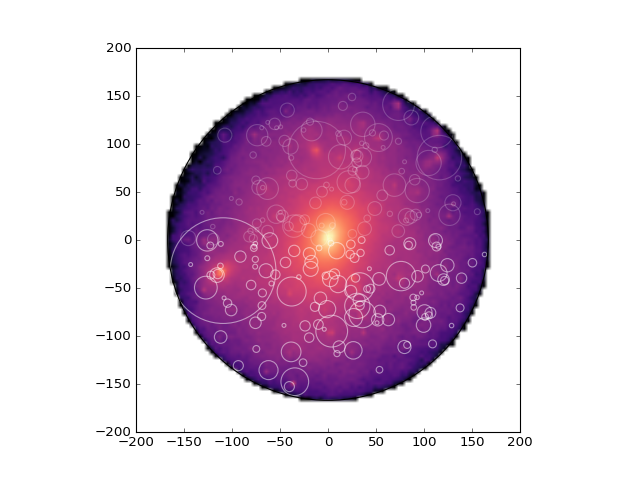

In [14]:
fig, ax = plt.subplots()
plt.imshow(Hz, interpolation='bilinear', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           norm=LogNorm(vmin=1e6, vmax=8e9))

#plt.imshow(Hz, interpolation='bilinear', origin='low',cmap='magma',
#         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#           norm=LogNorm(vmin=1e6, vmax=8e9))

for i in range(0,len(halos_r)):
    if halos_rvir[i] == halos_rvir.max():
        continue
    if halos_z[i] < 0:
        alpha=0.5
    else:
        alpha=0.2
    circle = plt.Circle(((halos_x[i]),(halos_z[i])),halos_rvir[i],
                        color='w',lw=1, fill=False,alpha=alpha)
    ax.add_patch( circle )

circle = plt.Circle(((0),(0)),myhalo.r200, color='k',lw=1, fill=False)
ax.add_patch( circle )

In [15]:
def get_cen_clump(i):
    if i%20==0:
        print i
    #define r^2 of particles centered in the ith halo
    par_r2 =  (myhalo.dm.pos3d[:,0]-halos_x[i])**2 + \
              (myhalo.dm.pos3d[:,1]-halos_y[i])**2 + \
              (myhalo.dm.pos3d[:,2]-halos_z[i])**2
    # finds particles (position and mass) inside 0.6 times the radius of halo
    clump = np.where(par_r2 < (halos_rvir[i] * 0.6)**2)
    clump_pos = myhalo.dm.pos3d[clump]
    clump_mass = myhalo.dm.mass[clump]
    # finds center
    center = nbe.real_center(clump_pos,clump_mass,n=int(len(clump[0])*0.2))
    return center[0],center[1], center[2]
getcen = np.vectorize(get_cen_clump)

    

# Selecting clumps by mass

In [24]:
#selects halos above mass_min times the DM particle mass
mass_min = 15
good_halos = np.where((halos_mass>mass_min*myhalo.dm.mass.min())&(halos_r > 2)) 
new_x, new_y, new_z = halos_x[good_halos], halos_y[good_halos], halos_z[good_halos]
new_rvir = halos_rvir[good_halos]
new_m  = halos_mass[good_halos]

In [25]:
xx,yy,zz = getcen(good_halos[0])

0
0
20
60
100
120
140
160
180
200


<IPython.core.display.Javascript object>


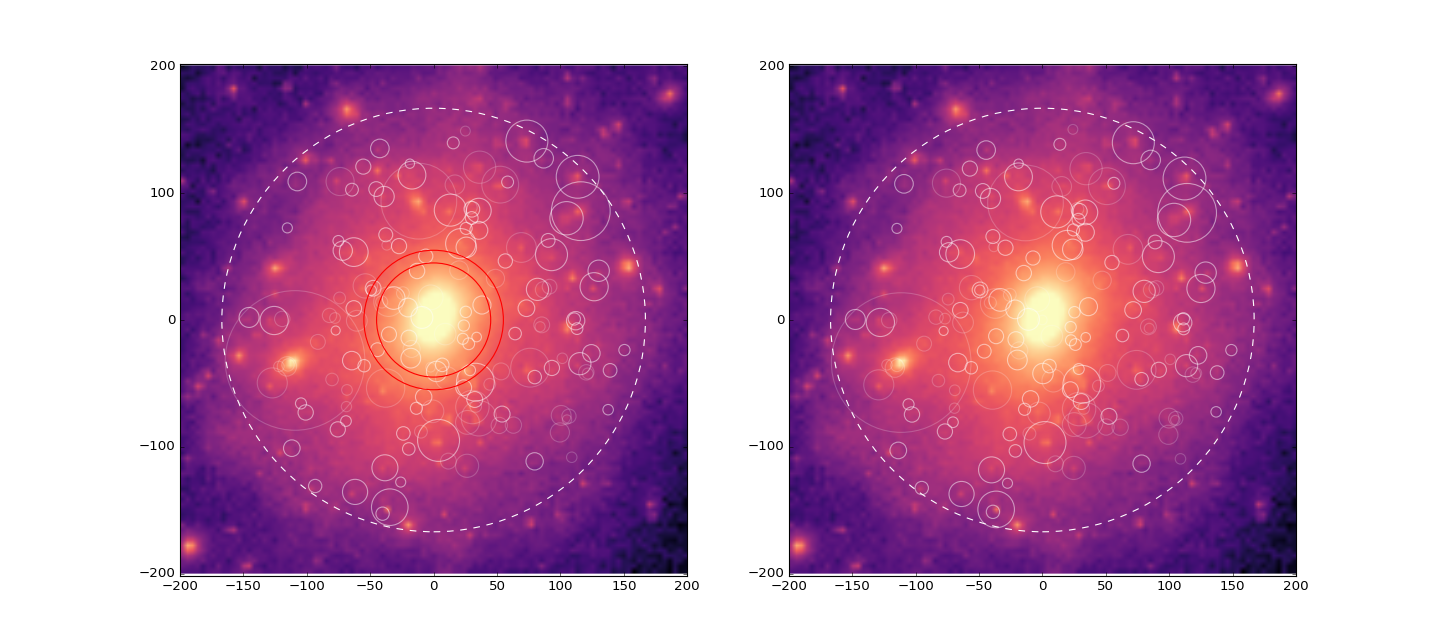

In [26]:
#fig, ax = plt.subplots()
plt.figure(figsize=[18,8])
ax = plt.subplot(1,2,1,aspect='equal')
ax1 = plt.subplot(1,2,2, sharex=ax,sharey=ax,aspect='equal')
ax.imshow(Hzb, interpolation='bilinear', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           norm=LogNorm(vmin=2e6, vmax=1e9))

ax1.imshow(Hzb, interpolation='bilinear', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           norm=LogNorm(vmin=2e6, vmax=1e9))

for i in range(0,len(new_x)):
    if new_rvir[i] == new_rvir.max():
        continue
    if halos_z[i] < 0:
        alpha=0.5
    else:
        alpha=0.2
    circle = plt.Circle(((new_x[i]),(new_z[i])),new_rvir[i],
                        color='w',lw=1, fill=False,alpha=alpha)
    ax.add_patch( circle )
    circle = plt.Circle(((xx[i]),(zz[i])),new_rvir[i],
                        color='w',lw=1, fill=False,alpha=alpha)
    ax1.add_patch( circle )

circle = plt.Circle(((0),(0)),myhalo.r200, color='w',ls='--',lw=1, fill=False)
ax.add_patch( circle )
circle = plt.Circle(((0),(0)),myhalo.r200, color='w',ls='--',lw=1, fill=False)
ax1.add_patch( circle )
circle = plt.Circle(((0),(0)),45, color='r',ls='-',lw=1, fill=False)
ax.add_patch( circle )
circle = plt.Circle(((0),(0)),55, color='r',ls='-',lw=1, fill=False)
ax.add_patch( circle )


In [27]:
# preserving badly center clumps
old_x = new_x
old_y = new_y
old_z = new_z
# redefining clumps center to the CM centers
new_x = xx
new_y = yy
new_z = zz

In [28]:
#particles inside
def particles_inside(i):
    pos = myhalo.dm.pos3d-[new_x[i], new_y[i], new_z[i]]
    r2 = pos[:,1]**2 +pos[:,1]**2 + pos[:,2]**2 
    return np.where(r2 < (new_rvir[i]**2))

get_inside = np.vectorize(particles_inside)

test = np.arange(0,5,1)
total_clump_particle_index = np.array([])
for i in np.where(new_rvir<100)[0]:
    total_clump_particle_index = np.append(total_clump_particle_index,particles_inside(i)[0])

total_clump_particle_index = np.array(np.unique(total_clump_particle_index),dtype=np.int)

mask = np.array([True for i in myhalo.dm.mass])
mask[total_clump_particle_index] *= False
# generates arrays of smooth component
print np.unique(mask)
smooth_pos3d = np.delete(myhalo.dm.pos3d,total_clump_particle_index)
smooth_x = np.delete(myhalo.dm.pos3d[:,0],total_clump_particle_index)
smooth_y = np.delete(myhalo.dm.pos3d[:,1],total_clump_particle_index)
smooth_z = np.delete(myhalo.dm.pos3d[:,2],total_clump_particle_index)
smooth_r = np.delete(myhalo.dm.r,total_clump_particle_index)
smooth_v = np.delete(myhalo.dm.v,total_clump_particle_index)
smooth_mass = np.delete(myhalo.dm.mass,total_clump_particle_index)


#creates 2dhistograms of both clump and smooth components
bin_num = 80
xedges = np.linspace(-200,200,bin_num)
yedges = np.linspace(-200,200,bin_num)
noclumps, xedgesNC, yedgesNC = np.histogram2d(smooth_x[(smooth_r<myhalo.r200)],
                                              smooth_z[(smooth_r<myhalo.r200)],
                                              bins=(xedges, yedges),
                                              weights=smooth_mass[(smooth_r<myhalo.r200)])
noclumps = noclumps.T

withclumps, xedgesWC, yedgesWC = np.histogram2d(myhalo.dm.pos3d[:,0],
                                       myhalo.dm.pos3d[:,2],
                                       bins=(xedges, yedges),
                                       weights=myhalo.dm.mass)
withclumps = withclumps.T

check, xedgesNC, yedgesNC = np.histogram2d(smooth_x[(np.abs(smooth_y)<5)],smooth_z[(np.abs(smooth_y)<5)],
                                       bins=(xedges, yedges),
                                       weights=smooth_mass[(np.abs(smooth_y)<5)])
noclumps = noclumps.T


[False  True]


<IPython.core.display.Javascript object>


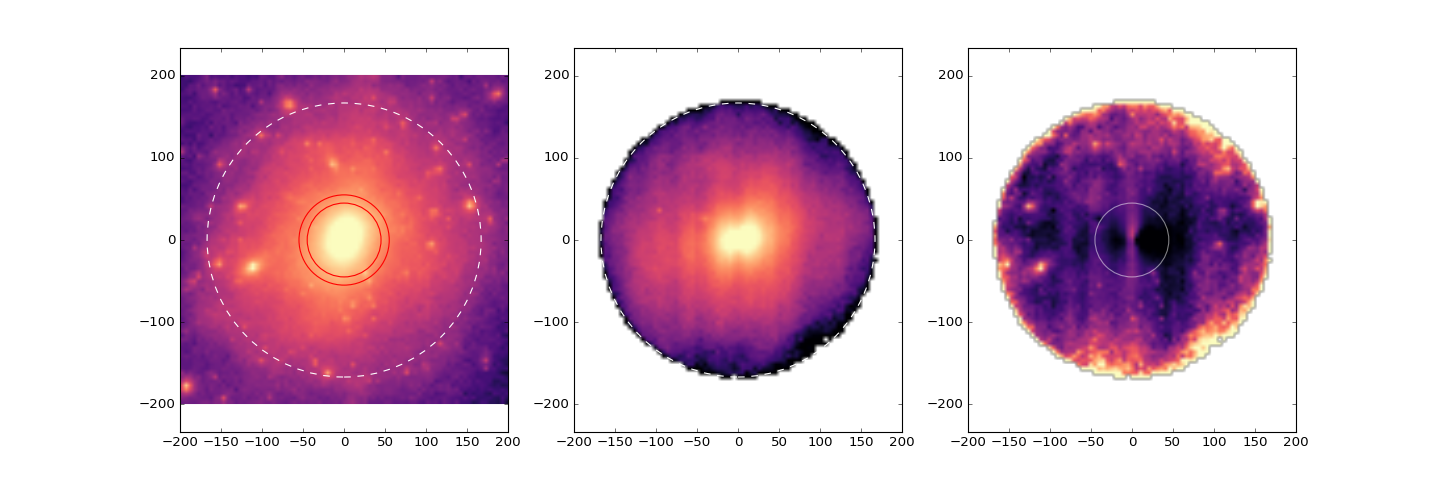

In [21]:
#fig, [ax,ax1,ax3] = plt.subplots(1,3,figsize=[18,6])
plt.figure(figsize=[18,6])
ax = plt.subplot(1,3,1,aspect='equal')
ax1 = plt.subplot(1,3,2, sharex=ax,sharey=ax,aspect='equal')
ax3 = plt.subplot(1,3,3, sharex=ax,sharey=ax,aspect='equal')
ax.imshow(withclumps, interpolation='bilinear', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           norm=LogNorm(vmin=2e6, vmax=1e9))

ax1.imshow(noclumps, interpolation='bilinear', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
           norm=LogNorm(vmin=2e6, vmax=1e9))
'''
for i in range(0,len(new_x)):
    if new_rvir[i] == new_rvir.max():
        continue
    if halos_z[i] < 0:
        alpha=0.5
    else:
        alpha=0.2
    circle = plt.Circle(((new_x[i]),(new_z[i])),new_rvir[i],
                        color='w',lw=1, fill=False,alpha=alpha)
    ax.add_patch( circle )
'''
circle = plt.Circle(((0),(0)),myhalo.r200, color='w',ls='--',lw=1, fill=False)
ax.add_patch( circle )
circle = plt.Circle(((0),(0)),myhalo.r200, color='w',ls='--',lw=1, fill=False)
ax1.add_patch( circle )
circle = plt.Circle(((0),(0)),45, color='r',ls='-',lw=1, fill=False)
ax.add_patch( circle )
circle = plt.Circle(((0),(0)),45, color='r',ls='-',lw=1, fill=False)
#ax1.add_patch( circle )
circle = plt.Circle(((0),(0)),45, color='w',ls='-',lw=1, alpha=0.5,fill=False)
ax3.add_patch( circle )

circle = plt.Circle(((0),(0)),55, color='r',ls='-',lw=1, fill=False)
ax.add_patch( circle )
circle = plt.Circle(((0),(0)),55, color='r',ls='-',lw=1, fill=False)
#ax1.add_patch( circle )
circle = plt.Circle(((0),(0)),55, color='w',ls='-',lw=1, alpha=0.5,fill=False)
#ax3.add_patch( circle )

ax3.imshow(withclumps/ noclumps, interpolation='bilinear', origin='low',cmap='magma',
         extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], norm=LogNorm(vmin=1e0, vmax=20))


# mass spectrum

In [29]:
new_r = np.sqrt(new_x**2 + new_y**2 + new_z**2)
hist, bins = np.histogram(new_r,bins=512,weights=new_m)

<IPython.core.display.Javascript object>


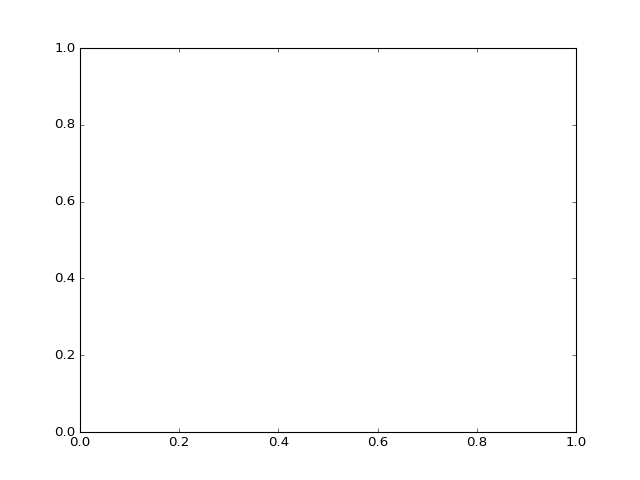

4.20384418478 kpc 6263361.9392 Msun 4.20384418478 kpc
5.24700894973 kpc 8351149.25226 Msun 5.24700894973 kpc
4.75204162507 kpc 9974983.51298 Msun 4.75204162507 kpc
5.98719737275 kpc 15078463.5326 Msun 5.98719737275 kpc
5.24700894973 kpc 11830794.2999 Msun 5.24700894973 kpc
6.82421512217 kpc 18790085.1063 Msun 6.82421512217 kpc
4.92820144334 kpc 6727314.2803 Msun 4.92820144334 kpc
6.27970948353 kpc 14150557.4279 Msun 6.27970948353 kpc
4.35410712529 kpc 5103480.01958 Msun 4.35410712529 kpc
5.90943246254 kpc 18558109.2914 Msun 5.90943246254 kpc
10.2510719141 kpc 74696385.9506 Msun 10.2510719141 kpc
5.39283324917 kpc 8815101.59337 Msun 5.39283324917 kpc
4.28029449479 kpc 6495338.46537 Msun 4.28029449479 kpc
6.2446263451 kpc 22501706.6801 Msun 6.2446263451 kpc
14.8970399551 kpc 242647279.945 Msun 14.8970399551 kpc
6.2446263451 kpc 25053447.7568 Msun 6.2446263451 kpc
3.77169785925 kpc 4871503.49341 Msun 3.77169785925 kpc
5.43972981369 kpc 9511030.46064 Msun 5.43972981369 kpc
5.29651199065 kp

In [67]:
fig, ax = plt.subplots()
#ax.set_yscale("log")
#ax.set_xlim([0,80])
#ax.set_ylim([8e6,1e11])

#ax.scatter(new_rvir,new_m,c=new_r*100/new_r.max())

for i in range(0,len(new_x)):
    print new_rvir[i],new_m[i],new_rvir[i]
    circle = plt.Circle(((new_rvir[i]),(new_m[i])),new_rvir[i],
                        color='k')
    ax.add_patch( circle )

#ax.set_xlabel("r [kpc]",fontsize=18)
#ax.set_ylabel(r"Subhalo mass [M$_{\odot}$]",fontsize=18)
#ax.axvline(x=30,linestyle='--',color='gray')
#ax.axhline(y=1e8,linestyle='--',color='gray')


<IPython.core.display.Javascript object>


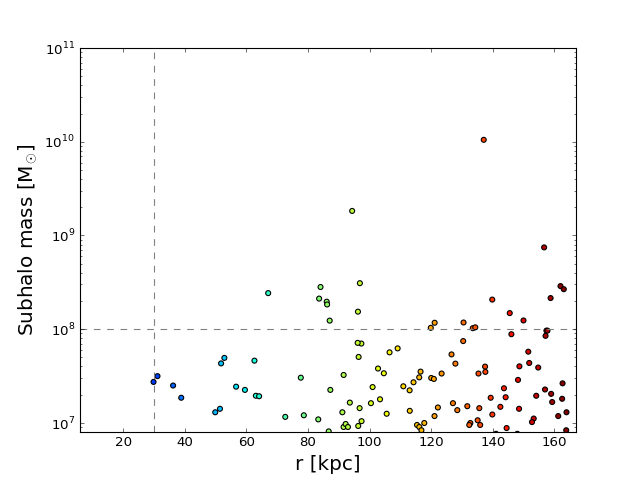

In [54]:
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_xlim([6,myhalo.r200])
ax.set_ylim([8e6,1e11])

ax.scatter(new_r,new_m,c=new_r*100/new_r.max())
ax.set_xlabel("r [kpc]",fontsize=18)
ax.set_ylabel(r"Subhalo mass [M$_{\odot}$]",fontsize=18)
ax.axvline(x=30,linestyle='--',color='gray')
ax.axhline(y=1e8,linestyle='--',color='gray')


In [24]:
print smooth_r.min(), smooth_r.max()

3.43615 417.478


<IPython.core.display.Javascript object>


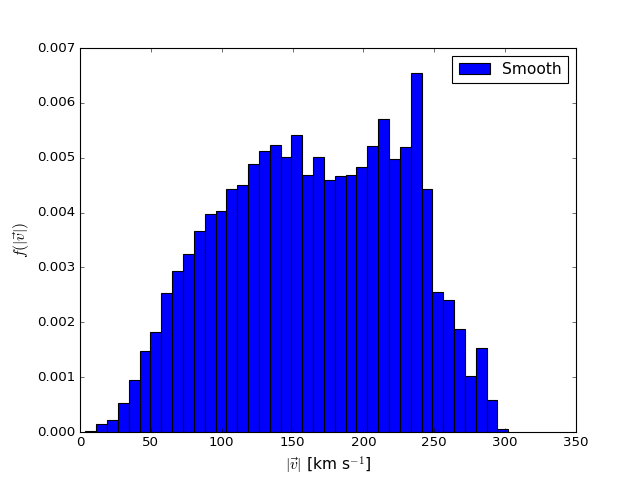

In [31]:
low_lim , upplim = 49,51
smooth_shell = (smooth_r > low_lim)&(smooth_r < upplim)
clumpy_shell = (myhalo.dm.r >low_lim)&(myhalo.dm.r < upplim)
bins = np.linspace(0,smooth_v[smooth_shell].max(),40)
smooth_hist, bins  = np.histogram(smooth_v[smooth_shell],bins=bins,normed=True)

fig, ax = plt.subplots()
ax.set_xlabel(r"$|\vec{v}|$ [km s$^{-1}$]",fontsize=14)
ax.set_ylabel(r"$f(|\vec{v}|)$",fontsize=14)
ax.bar(bins[1:]-bins[1]/2.,smooth_hist,width=bins[1],label="Smooth")
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()

<IPython.core.display.Javascript object>


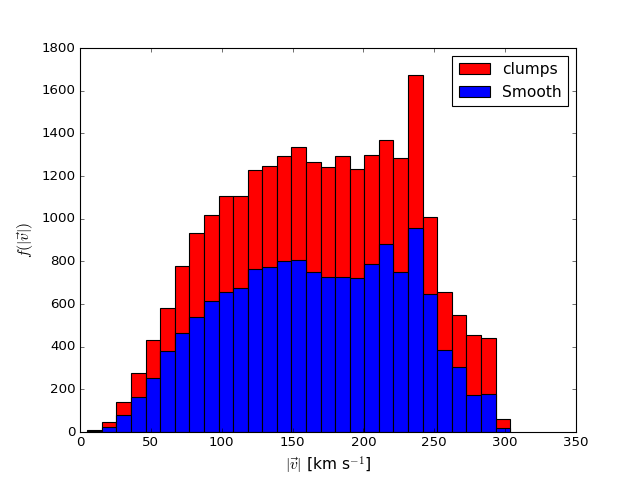

In [32]:
low_lim , upplim = 49,51
smooth_shell = (smooth_r > low_lim)&(smooth_r < upplim)
clumpy_shell = (myhalo.dm.r >low_lim)&(myhalo.dm.r < upplim)
bins = np.linspace(0,smooth_v[smooth_shell].max(),30)
smooth_hist, bins  = np.histogram(smooth_v[smooth_shell],bins=bins)#,normed=True)
clumpy_hist, bins  = np.histogram(myhalo.dm.v[clumpy_shell],bins=bins)#,normed=True)

fig, ax = plt.subplots()
ax.set_xlabel(r"$|\vec{v}|$ [km s$^{-1}$]",fontsize=14)
ax.set_ylabel(r"$f(|\vec{v}|)$",fontsize=14)
ax.bar(bins[1:]-bins[1]/2.,clumpy_hist,width=bins[1],color='r',label="clumps")
ax.bar(bins[1:]-bins[1]/2.,smooth_hist,width=bins[1],label="Smooth")
legend = ax.legend(loc='upper right', ncol=1, shadow=False, fontsize=14)
frame = legend.get_frame()


14999 25369


<IPython.core.display.Javascript object>


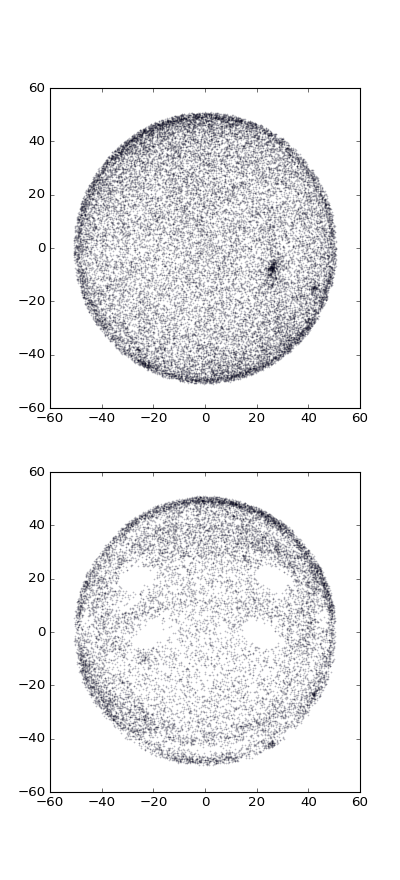

In [33]:
print len(smooth_v[smooth_shell]),len(myhalo.dm.v[clumpy_shell])
fig,ax = plt.subplots(2,1,figsize=[5,11])
ax[0].scatter(myhalo.dm.pos3d[clumpy_shell,0],myhalo.dm.pos3d[clumpy_shell,1],s=0.2,alpha=0.3)
ax[1].scatter(smooth_x[smooth_shell],smooth_z[smooth_shell],s=0.2,alpha=0.3)

In [34]:
def overlap(ax,path,rmin,rmax,title="title",plot_smooth=True,plot_full=True):
    v = np.array([])
    fv = np.array([])
    
    files = open(path)
    for line in files:
        row = line.split(' ')
        if np.isnan(float(row[3][:-1])):
            continue
        v = np.append(v,float(row[0]))
        fv = np.append(fv,float(row[3][:-1]))
    shell = (smooth_r>rmin)&(smooth_r<rmax)
    shell_wc = (myhalo.dm.r>rmin)&(myhalo.dm.r<rmax)
    local_v = smooth_v[shell]
    local_v_wc = myhalo.dm.v[shell_wc]
    hist, bins = np.histogram(smooth_v[shell],bins=np.linspace(0,v.max()*1.2,30),normed=True)
    hist_wc, bins_wc = np.histogram(myhalo.dm.v[shell_wc],bins=np.linspace(0,v.max()*1.2,30),normed=True)
    ax.set_title(title,fontsize=18)
    ax.set_xlabel(r"$|\vec{v}|$ [km/s]", fontsize=20)
    ax.set_ylabel(r"$f(|\vec{v}|)$", fontsize=20)
    ax.text(np.mean(local_v)*0.5/10, fv.max()*1.03,r"mean = {0:.2f} km/s".format(np.mean(local_v)),fontsize=13)
    ax.set_xlim([0,bins.max()])
    ax.set_ylim([0,(hist_wc * len(myhalo.dm.v[shell_wc]) / len(smooth_v[shell])).max()*13/10])
    if (plot_full):
        ax.bar(bins_wc[1:]-bins_wc[1]/2., hist_wc * len(myhalo.dm.v[shell_wc]) / len(smooth_v[shell]), width=bins_wc[1],
               label="smooth + clumps",color='g',alpha=0.2)
    if (plot_smooth):
        ax.bar(bins[1:]-bins[1]/2., hist, width=bins[1],
               label="smooth",color= 'gray',alpha=0.6)
    ax.plot(v,fv ,'r',label="eddington")
    legend = ax.legend(loc='upper left', ncol=1, shadow=False,fontsize=13)
    

<IPython.core.display.Javascript object>


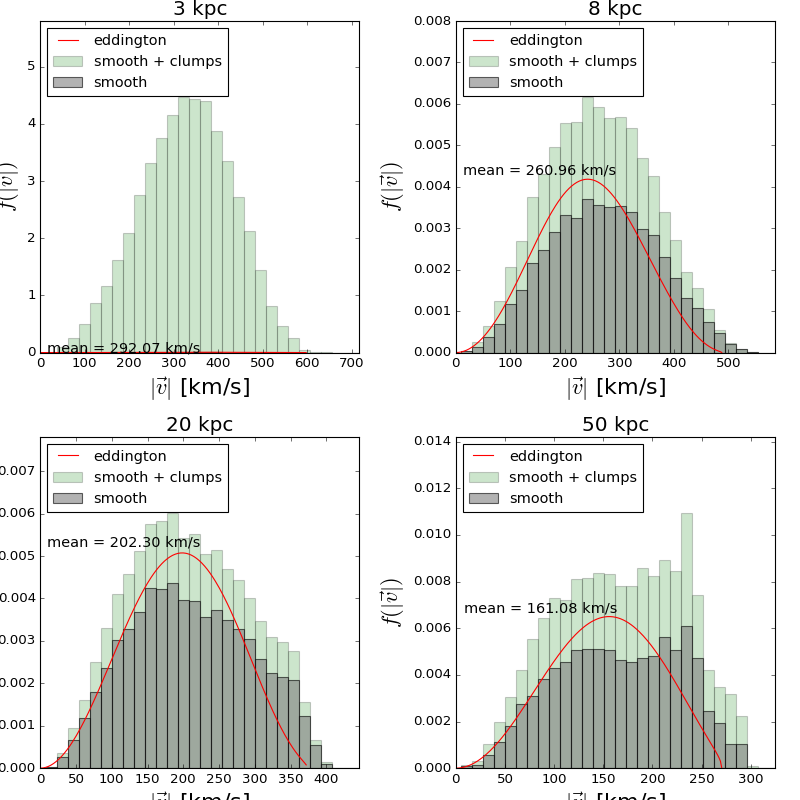

In [35]:
fig,[[ax,ax1],[ax2,ax3]]=plt.subplots(2,2,figsize=[10,10])
plt.tight_layout(h_pad=4.5,w_pad=4.5)
overlap(ax1,'/home/arturo/Downloads/fv_df0_model13_bar3_r8_rmax500_div0 (1).dat',
        7.5,8.5,title="8 kpc")
overlap(ax2,'/home/arturo/Downloads/fv_df0_model13_bar3_r20_rmax500_div0 (1).dat',
        19.5,20.5,title="20 kpc")
overlap(ax,'/home/arturo/Downloads/fv_df0_model13_bar3_r3_rmax500_div0 (1).dat',
        2.5,3.5,title="3 kpc")
overlap(ax3,'/home/arturo/Downloads/fv_df0_model13_bar3_r50_rmax500_div0 (1).dat',
        49.5,50.5,title="50 kpc")

In [36]:
print myhalo.dm.mass[0]

230813.0


In [37]:
v = np.array([])
fv = np.array([])
path = '/home/arturo/Downloads/fv_df0_model13_bar3_r8_rmax500_div0 (1).dat'    
files = open(path)
for line in files:
    row = line.split(' ')
    if np.isnan(float(row[3][:-1])):
        continue
    v = np.append(v,float(row[0]))
    fv = np.append(fv,float(row[3][:-1]))

In [38]:
f = interp1d(v,fv)


In [39]:
shell_wc = (myhalo.dm.r>7.5)&(myhalo.dm.r<8.5)
local_v_wc = myhalo.dm.v[shell_wc]
Ntot=len(local_v_wc)
bins = np.linspace(0,local_v_wc.max(),30)
hist_wc, bins_wc = np.histogram(myhalo.dm.v[shell_wc],bins=bins,normed=True)
x = (bins_wc[1:]+bins_wc[:-1])/2


In [40]:
fv_the = np.array([])
sigma_1 = np.array([])
sigma_2 = np.array([])
sigma_x = np.array([])
N = np.array([])
test = np.array([])
means = np.array([])
for i in range(len(bins_wc)-1):
    try:
        fv_the = np.append(fv_the, quad(f,bins_wc[i],bins_wc[i+1])[0] / (bins_wc[i+1] - bins_wc[i]))
        test = np.append(test,(bins_wc[i+1]+ bins_wc[i])/2)
        pop = local_v_wc[(local_v_wc>bins_wc[i])&(local_v_wc<=bins_wc[i+1])]
        means, N = np.append(means,np.average(pop)), np.append(N,len(pop))
        #Ntot += N[-1]
        sigma_x = np.append(sigma_x,np.std(pop))
        sigma_1 = np.append(sigma_1, mean/ np.sqrt(N))
        sigma_2 = np.append(sigma_2, np.sqrt(np.abs(mean**2 - np.mean(pop**2))))
    except:
        print "nones for ", i
    
print fv_the
Ntot = np.trapz(N,x=means)

nones for  0
nones for  1
nones for  2
nones for  3
nones for  4
nones for  5
nones for  6
nones for  7
nones for  8
nones for  9
nones for  10
nones for  11
nones for  12
nones for  13
nones for  14
nones for  15
nones for  16
nones for  17
nones for  18
nones for  19
nones for  20
nones for  21
nones for  22
nones for  23
nones for  24
nones for  25
nones for  26
nones for  27
nones for  28
[  1.73438667e-05   1.20037058e-04   3.22910420e-04   6.20173959e-04
   1.00162855e-03   1.45136223e-03   1.94703381e-03   2.46030430e-03
   2.95870664e-03   3.40770137e-03   3.77382272e-03   4.03015024e-03
   4.16101328e-03   4.15932660e-03   4.02676223e-03   3.77683017e-03
   3.43028811e-03   3.01276939e-03   2.55321772e-03   2.07824969e-03
   1.61202042e-03   1.17572701e-03   7.87880491e-04   4.67660078e-04
   2.30387318e-04   7.75001831e-05]


In [41]:
sigma = np.sqrt(N) / Ntot
chi2 = np.sum(((N/Ntot) - fv_the)**2 / sigma**2)
print chi2/26

30.2944650812


In [42]:
print len(means),len((bins[1:]-bins[:-1])[:26])

26 26


<IPython.core.display.Javascript object>


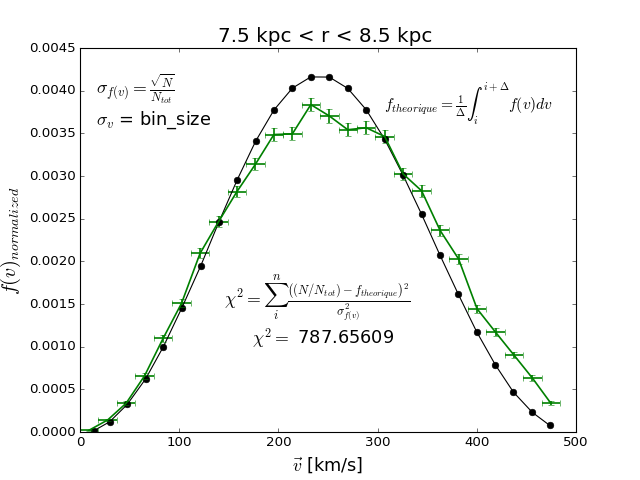

In [43]:
fig, ax = plt.subplots()
ax.plot(means,fv_the,'ko-')#,yerr=means/np.sqrt(N),xerr=sigma_x)
ax.errorbar(test,N/Ntot,yerr=np.sqrt(N)/Ntot,xerr=((bins[1:]-bins[:-1])/2.)[:26],c='g',lw=1.5 )
ax.set_xlabel(r"$\vec{v}$ [km/s]",fontsize=16)
ax.set_ylabel(r"$f(v)_{normalized} $ ",fontsize=18)
texto_izquierda = r"$\sigma_{f(v)} = \frac{\sqrt{N}}{N_{tot}}$"
texto_izquierda += "\n"
texto_izquierda += r"$\sigma_{v}$ = bin_size"
fig.text(0.15,0.75,texto_izquierda,fontsize=16)
texto_centro = r"$\chi^2 = \sum_{i}^n \frac{\left((N/N_{tot}) - f_{theorique}\right)^2}{\sigma_{f(v)}^2}$"
texto_centro += "\n"
texto_centro += "     $\chi^2 = $ {0:.5f}".format(chi2)
fig.text(0.35,0.3,texto_centro,fontsize=16)
texto_derecha = r"$f_{theorique} = \frac{1}{\Delta} \int_{i}^{i+\Delta} f(v)dv$"
fig.text(0.6,0.77,texto_derecha,fontsize=14)
ax.set_title("7.5 kpc < r < 8.5 kpc ", fontsize=18)
#ax.plot(v,fv,'r-')

In [38]:
print np.trapz(N,x=means), Ntot



601597.347786 601597.347786


In [44]:
r_s = np.logspace(-1,np.log10(myhalo.r200),30)
mass, bins = np.histogram(smooth_r,bins=r_s,weights=smooth_mass)
mass_wc, bins_wc = np.histogram(myhalo.dm.r,bins=r_s,weights=myhalo.dm.mass)
volume = 4. * np.pi * (bins[1:]**3 - bins[:-1]**3)/3. 
volume_wc = 4. * np.pi * (bins_wc[1:]**3 - bins_wc[:-1]**3)/3. 
rho = mass / volume
rho_wc = mass_wc / volume_wc
r_array = (bins[1:] - bins[:-1])/2
r_array_wc = (bins_wc[1:] - bins_wc[:-1])/2


In [45]:
ok,rho_dm_wc,_= CF.getDensity(np.array(myhalo.dm.pos3d.reshape(len(myhalo.dm.pos3d)*3),dtype=np.float32), myhalo.dm.mass)

In [ ]:
#### beware Super Slow!!!!
smooth_pos3d = np.array([])
for i in range(len(smooth_x)):
    smooth_pos3d = np.append(smooth_pos3d,[smooth_x[i],smooth_y[i],smooth_z[i]])

In [ ]:
ok,rho_dm_smooth,_= CF.getDensity(np.array(smooth_pos3d.reshape(len(smooth_pos3d)*3),dtype=np.float32), smooth_mass)

In [ ]:
fig,ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(r_array_wc,rho_wc)